# Part 2 : Improved Model

## Setup

In [2]:
# Imports
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# Loading data
data_files = ["../data/data0.npy", "../data/data1.npy", "../data/data2.npy"]
label_files = ["../data/lab0.npy", "../data/lab1.npy", "../data/lab2.npy"]

data = [np.load(file) for file in data_files]
label = [np.load(file) for file in label_files]

images = np.concatenate(data)
labels = np.concatenate(label)

In [4]:
# Data -> Dataloader
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)


# Image Transform (for grayscale images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize((0.5,), (0.5,))
])

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.85, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, train_size=0.85, random_state=42)
batch_size = 1024
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Using pretrained resnet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
n_classes = 37 # all possible sums from 0 to 36
# model.fc = nn.Linear(model.fc.in_features, 37)
model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
model.to(device)

# Run model parallely with multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Multiple GPUs found: {torch.cuda.device_count()}")
    model = nn.DataParallel(model)

Multiple GPUs found: 4


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [8]:
def train():
    model.train()
    loss = 0.0
    correct, total = 0, 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    accuracy = 100 * correct / total
    return loss, accuracy

def validate():
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return loss, accuracy

In [9]:
# Training Loop
num_epochs = 50
train_loss, val_loss, train_accuracy, val_accuracy = [], [], [], []
best_model = None
best_accuracy = 0.0
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    loss, accuracy = train()
    train_loss.append(loss.item())
    train_accuracy.append(accuracy)
    loss, accuracy = validate()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()
    val_loss.append(loss.item())
    val_accuracy.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%\nValidation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_accuracy[-1]:.2f}%")

Epochs:   2%|▏         | 1/50 [00:17<14:00, 17.16s/it]

Epoch [1/50]
Train Loss: 5.2181, Train Accuracy: 9.86%
Validation Loss: 5.1582, Validation Accuracy: 12.47%


Epochs:   4%|▍         | 2/50 [00:27<10:31, 13.16s/it]

Epoch [2/50]
Train Loss: 4.1276, Train Accuracy: 18.81%
Validation Loss: 4.8912, Validation Accuracy: 15.56%


Epochs:   6%|▌         | 3/50 [00:37<09:18, 11.88s/it]

Epoch [3/50]
Train Loss: 3.7776, Train Accuracy: 25.26%
Validation Loss: 3.8391, Validation Accuracy: 25.49%


Epochs:   8%|▊         | 4/50 [00:48<08:39, 11.30s/it]

Epoch [4/50]
Train Loss: 3.5058, Train Accuracy: 32.88%
Validation Loss: 3.3481, Validation Accuracy: 34.93%


Epochs:  10%|█         | 5/50 [00:58<08:14, 10.98s/it]

Epoch [5/50]
Train Loss: 4.8894, Train Accuracy: 38.74%
Validation Loss: 3.2215, Validation Accuracy: 35.37%


Epochs:  12%|█▏        | 6/50 [01:09<07:54, 10.78s/it]

Epoch [6/50]
Train Loss: 3.7222, Train Accuracy: 44.33%
Validation Loss: 2.7670, Validation Accuracy: 46.25%


Epochs:  14%|█▍        | 7/50 [01:19<07:38, 10.67s/it]

Epoch [7/50]
Train Loss: 3.6784, Train Accuracy: 46.54%
Validation Loss: 4.0662, Validation Accuracy: 30.85%


Epochs:  16%|█▌        | 8/50 [01:29<07:23, 10.57s/it]

Epoch [8/50]
Train Loss: 2.5730, Train Accuracy: 48.63%
Validation Loss: 3.3785, Validation Accuracy: 30.75%


Epochs:  18%|█▊        | 9/50 [01:40<07:14, 10.59s/it]

Epoch [9/50]
Train Loss: 2.8614, Train Accuracy: 53.28%
Validation Loss: 2.6045, Validation Accuracy: 44.31%


Epochs:  20%|██        | 10/50 [01:50<07:01, 10.53s/it]

Epoch [10/50]
Train Loss: 2.4536, Train Accuracy: 57.25%
Validation Loss: 2.6279, Validation Accuracy: 55.14%


Epochs:  22%|██▏       | 11/50 [02:01<06:47, 10.44s/it]

Epoch [11/50]
Train Loss: 3.3105, Train Accuracy: 58.93%
Validation Loss: 4.4035, Validation Accuracy: 16.44%


Epochs:  24%|██▍       | 12/50 [02:11<06:33, 10.35s/it]

Epoch [12/50]
Train Loss: 4.3271, Train Accuracy: 57.17%
Validation Loss: 2.0382, Validation Accuracy: 64.00%


Epochs:  26%|██▌       | 13/50 [02:21<06:23, 10.37s/it]

Epoch [13/50]
Train Loss: 3.1704, Train Accuracy: 61.34%
Validation Loss: 2.1866, Validation Accuracy: 60.08%


Epochs:  28%|██▊       | 14/50 [02:31<06:12, 10.33s/it]

Epoch [14/50]
Train Loss: 1.9254, Train Accuracy: 68.08%
Validation Loss: 1.8316, Validation Accuracy: 68.39%


Epochs:  30%|███       | 15/50 [02:42<06:01, 10.32s/it]

Epoch [15/50]
Train Loss: 3.4197, Train Accuracy: 65.62%
Validation Loss: 1.9864, Validation Accuracy: 66.93%


Epochs:  32%|███▏      | 16/50 [02:52<05:50, 10.32s/it]

Epoch [16/50]
Train Loss: 4.7463, Train Accuracy: 58.21%
Validation Loss: 3.3409, Validation Accuracy: 35.35%


Epochs:  34%|███▍      | 17/50 [03:03<05:42, 10.38s/it]

Epoch [17/50]
Train Loss: 2.1058, Train Accuracy: 65.25%
Validation Loss: 1.7986, Validation Accuracy: 67.61%


Epochs:  36%|███▌      | 18/50 [03:13<05:29, 10.31s/it]

Epoch [18/50]
Train Loss: 1.8738, Train Accuracy: 71.17%
Validation Loss: 1.6041, Validation Accuracy: 77.15%


Epochs:  38%|███▊      | 19/50 [03:23<05:17, 10.23s/it]

Epoch [19/50]
Train Loss: 2.4842, Train Accuracy: 69.20%
Validation Loss: 1.8632, Validation Accuracy: 73.99%


Epochs:  40%|████      | 20/50 [03:33<05:05, 10.20s/it]

Epoch [20/50]
Train Loss: 2.9628, Train Accuracy: 74.92%
Validation Loss: 1.7702, Validation Accuracy: 70.09%


Epochs:  42%|████▏     | 21/50 [03:43<04:56, 10.21s/it]

Epoch [21/50]
Train Loss: 2.6219, Train Accuracy: 74.01%
Validation Loss: 2.0175, Validation Accuracy: 68.31%


Epochs:  44%|████▍     | 22/50 [03:53<04:45, 10.18s/it]

Epoch [22/50]
Train Loss: 3.4315, Train Accuracy: 76.29%
Validation Loss: 3.9606, Validation Accuracy: 42.64%


Epochs:  46%|████▌     | 23/50 [04:03<04:35, 10.20s/it]

Epoch [23/50]
Train Loss: 1.8377, Train Accuracy: 73.54%
Validation Loss: 1.5902, Validation Accuracy: 80.10%


Epochs:  48%|████▊     | 24/50 [04:14<04:24, 10.18s/it]

Epoch [24/50]
Train Loss: 3.4149, Train Accuracy: 70.49%
Validation Loss: 6.0651, Validation Accuracy: 13.28%


Epochs:  50%|█████     | 25/50 [04:24<04:16, 10.26s/it]

Epoch [25/50]
Train Loss: 2.4914, Train Accuracy: 56.78%
Validation Loss: 2.1863, Validation Accuracy: 59.95%


Epochs:  52%|█████▏    | 26/50 [04:34<04:05, 10.24s/it]

Epoch [26/50]
Train Loss: 3.0713, Train Accuracy: 78.89%
Validation Loss: 1.9018, Validation Accuracy: 68.97%


Epochs:  54%|█████▍    | 27/50 [04:45<03:55, 10.24s/it]

Epoch [27/50]
Train Loss: 2.3818, Train Accuracy: 77.41%
Validation Loss: 1.3225, Validation Accuracy: 80.21%


Epochs:  56%|█████▌    | 28/50 [04:55<03:45, 10.25s/it]

Epoch [28/50]
Train Loss: 1.6657, Train Accuracy: 83.49%
Validation Loss: 1.2631, Validation Accuracy: 84.05%


Epochs:  58%|█████▊    | 29/50 [05:05<03:36, 10.30s/it]

Epoch [29/50]
Train Loss: 1.6757, Train Accuracy: 85.45%
Validation Loss: 1.1270, Validation Accuracy: 84.39%


Epochs:  60%|██████    | 30/50 [05:15<03:25, 10.30s/it]

Epoch [30/50]
Train Loss: 2.5932, Train Accuracy: 84.49%
Validation Loss: 1.8771, Validation Accuracy: 69.46%


Epochs:  62%|██████▏   | 31/50 [05:26<03:15, 10.28s/it]

Epoch [31/50]
Train Loss: 1.6075, Train Accuracy: 78.53%
Validation Loss: 1.6206, Validation Accuracy: 77.86%


Epochs:  64%|██████▍   | 32/50 [05:36<03:05, 10.29s/it]

Epoch [32/50]
Train Loss: 1.8162, Train Accuracy: 72.30%
Validation Loss: 1.5692, Validation Accuracy: 69.07%


Epochs:  66%|██████▌   | 33/50 [05:47<02:56, 10.37s/it]

Epoch [33/50]
Train Loss: 1.3717, Train Accuracy: 82.89%
Validation Loss: 1.2724, Validation Accuracy: 82.90%


Epochs:  68%|██████▊   | 34/50 [05:57<02:45, 10.37s/it]

Epoch [34/50]
Train Loss: 1.5649, Train Accuracy: 86.25%
Validation Loss: 1.6282, Validation Accuracy: 82.41%


Epochs:  70%|███████   | 35/50 [06:07<02:35, 10.36s/it]

Epoch [35/50]
Train Loss: 1.6677, Train Accuracy: 88.68%
Validation Loss: 1.3705, Validation Accuracy: 85.07%


Epochs:  72%|███████▏  | 36/50 [06:18<02:24, 10.35s/it]

Epoch [36/50]
Train Loss: 1.8044, Train Accuracy: 87.28%
Validation Loss: 1.0680, Validation Accuracy: 86.90%


Epochs:  74%|███████▍  | 37/50 [06:28<02:15, 10.41s/it]

Epoch [37/50]
Train Loss: 1.4622, Train Accuracy: 84.67%
Validation Loss: 1.8487, Validation Accuracy: 71.50%


Epochs:  76%|███████▌  | 38/50 [06:39<02:04, 10.40s/it]

Epoch [38/50]
Train Loss: 1.8444, Train Accuracy: 87.39%
Validation Loss: 1.3537, Validation Accuracy: 82.61%


Epochs:  78%|███████▊  | 39/50 [06:49<01:54, 10.40s/it]

Epoch [39/50]
Train Loss: 1.8374, Train Accuracy: 89.27%
Validation Loss: 1.2417, Validation Accuracy: 83.48%


Epochs:  80%|████████  | 40/50 [06:59<01:43, 10.39s/it]

Epoch [40/50]
Train Loss: 0.6883, Train Accuracy: 91.80%
Validation Loss: 1.6858, Validation Accuracy: 84.26%


Epochs:  82%|████████▏ | 41/50 [07:10<01:34, 10.46s/it]

Epoch [41/50]
Train Loss: 2.6684, Train Accuracy: 93.00%
Validation Loss: 1.1387, Validation Accuracy: 89.02%


Epochs:  84%|████████▍ | 42/50 [07:20<01:23, 10.41s/it]

Epoch [42/50]
Train Loss: 1.5953, Train Accuracy: 91.45%
Validation Loss: 1.1709, Validation Accuracy: 88.31%


Epochs:  86%|████████▌ | 43/50 [07:30<01:12, 10.36s/it]

Epoch [43/50]
Train Loss: 1.7791, Train Accuracy: 91.86%
Validation Loss: 1.5274, Validation Accuracy: 75.27%


Epochs:  88%|████████▊ | 44/50 [07:41<01:02, 10.34s/it]

Epoch [44/50]
Train Loss: 2.7387, Train Accuracy: 80.18%
Validation Loss: 1.4010, Validation Accuracy: 83.63%


Epochs:  90%|█████████ | 45/50 [07:51<00:51, 10.38s/it]

Epoch [45/50]
Train Loss: 1.3535, Train Accuracy: 90.69%
Validation Loss: 1.2300, Validation Accuracy: 88.21%


Epochs:  92%|█████████▏| 46/50 [08:02<00:41, 10.34s/it]

Epoch [46/50]
Train Loss: 0.9714, Train Accuracy: 92.18%
Validation Loss: 1.1618, Validation Accuracy: 85.70%


Epochs:  94%|█████████▍| 47/50 [08:12<00:30, 10.30s/it]

Epoch [47/50]
Train Loss: 1.0302, Train Accuracy: 92.58%
Validation Loss: 1.2542, Validation Accuracy: 82.93%


Epochs:  96%|█████████▌| 48/50 [08:22<00:20, 10.27s/it]

Epoch [48/50]
Train Loss: 1.4692, Train Accuracy: 91.99%
Validation Loss: 1.2136, Validation Accuracy: 84.47%


Epochs:  98%|█████████▊| 49/50 [08:32<00:10, 10.35s/it]

Epoch [49/50]
Train Loss: 1.4505, Train Accuracy: 91.89%
Validation Loss: 1.2145, Validation Accuracy: 82.25%


Epochs: 100%|██████████| 50/50 [08:43<00:00, 10.46s/it]

Epoch [50/50]
Train Loss: 0.7623, Train Accuracy: 91.07%
Validation Loss: 1.4442, Validation Accuracy: 89.70%


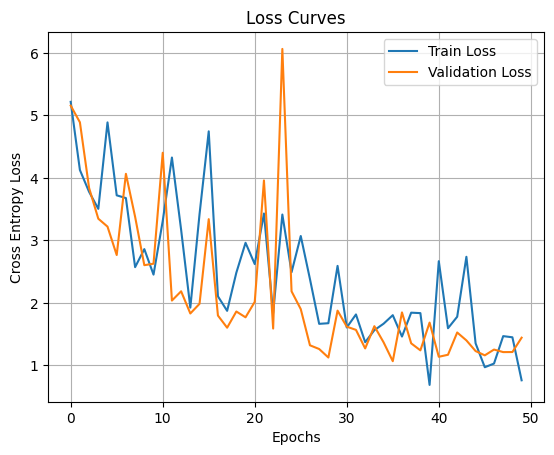

In [10]:
# Loss Curve
plt.figure()
plt.plot(range(num_epochs), train_loss, label="Train Loss")
plt.plot(range(num_epochs), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss Curves")
plt.grid(True)
plt.legend()
plt.show()

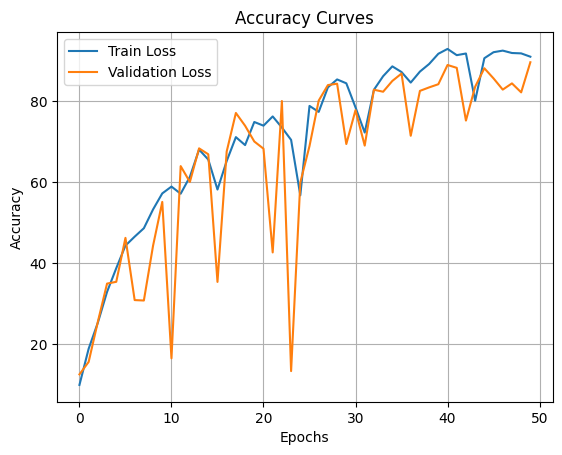

In [12]:
# Accuracy Curve
plt.figure()
plt.plot(range(num_epochs), train_accuracy, label="Train Loss")
plt.plot(range(num_epochs), val_accuracy, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# Saving trained model
torch.save(best_model, "best_resnet.pth")

## Inference

In [15]:
# Testing/Inference
def test():
    model.eval()
    correct, total, mae = 0, 0, 0
    with torch.no_grad():
        loss = 0.0
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            mae += torch.abs(predictions.float() - labels.float()).sum().item()
    acc = correct/total
    mae /= total
    return acc, mae

acc, mae = test()

In [17]:
print(f"The accuracy over the test dataset is {100*acc:.2f}% and the average MAE is {mae:.2f}")

The accuracy over the test dataset is 89.69% and the average MAE is 0.16
